개고양이 250000장의 이미지

미리 훈련시킨 모델을 가져와서 사용

confusion matrix, 특징맵, Grad_cam

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-rc1
!pip install tf-hub-nightly
!pip install -q h5py pyyaml

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
from glob import glob
import pathlib

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


%matplotlib inline

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 4.3MB 48.0MB/s 
     |████████████████████████████████| 501kB 55.7MB/s 
     |████████████████████████████████| 102kB 7.2MB/s 


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = '/content/gdrive/My Drive/dataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')


In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test= num_cats_test + num_dogs_test

print(total_train)
print(total_val)
print(total_test)

17000
4000
4000


In [0]:
import pathlib

test_dir = pathlib.Path(test_dir)
CLASS_NAMES = np.array([item.name for item in test_dir.glob('*') if item.name != "LICENSE.txt"])

In [0]:
# print('total training cat images:', len(os.listdir(train_cat_path)))
# print('total training dog images:', len(os.listdir(train_dog_path)))
# print('total validation cat images:', len(os.listdir(val_cat_path)))
# print('total validation dog images:', len(os.listdir(val_dog_path)))

In [0]:
#하이퍼파라미터 초기화
batch_size = 20
epochs = 90
IMG_HEIGHT = 244
IMG_WIDTH = 224

train_image_generator = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
# #각 데이터셋 그래프 그리기

# def plot_value_array(i, data, data2, title):
#   class_name = ['cat', 'dog']
#   class_len = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 8500]

#   plt.subplot(1, 3, i)
#   plt.xticks(range(2), class_name)
#   plt.yticks(class_len)
#   plt.title("{}_data".format(title))
#   plt.bar(0, data)
#   plt.bar(1, data2)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 17000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [0]:
# input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')
# def vgg16_model(input_data):
#   x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_data)
#   x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = BatchNormalization()(x)
#   x = MaxPooling2D((2,2))(x)
 
#   x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = BatchNormalization()(x)
#   x = MaxPooling2D((2,2))(x)

#   x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = BatchNormalization()(x)
#   x = MaxPooling2D((2,2))(x)

#   x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = BatchNormalization()(x)
#   x = MaxPooling2D((2,2))(x)

#   x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
#   x = BatchNormalization()(x)
#   x = MaxPooling2D((2,2))(x)

#   x = Flatten()(x)
#   x = Dense(256, activation='relu')(x)
#   x = BatchNormalization()(x)
#   x = Dense(1, activation='sigmoid')(x)

#   RMSprop = tf.optimizers.RMSprop(lr=1e-4, momentum=0.9)

#   vgg16.compile(optimizer=RMSprop,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

#   return Model(input_data, x)

In [0]:
# from keras import models
import tensorflow as tf

new_model = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/vgg_model_270.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# print("Evaluate")
# scores = new_model.evaluate_generator(test_data_gen, steps=200)
# print("%s: %.2f%%" %(vgg16.metrics_names[1], scores[1]*100))
# print("%s: %.2f%%" %(vgg16.metrics_names[0], scores[0]*100))

print("Predict")
pred = new_model.predict_generator(test_data_gen, steps=200, verbose=1)

Predict
200/200 [==============================] - 1767s 9s/step


In [0]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

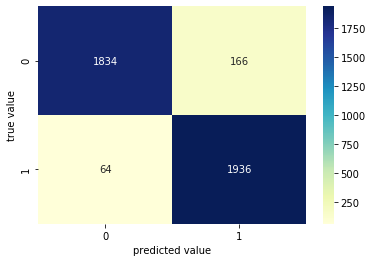

In [0]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(test_data_gen.classes, predict_data4)
#print(conf_matrix)
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

In [0]:
print("Evaluate")
scores = new_model.evaluate_generator(test_data_gen, steps=200)
print("%s: %.2f%%" %(new_model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(new_model.metrics_names[0], scores[0]*100))

Evaluate
accuracy: 94.25%
loss: 14.53%


In [0]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 244, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 244, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 244, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 244, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 112, 128)     147584

#hitmap 

(1, 244, 224, 3)


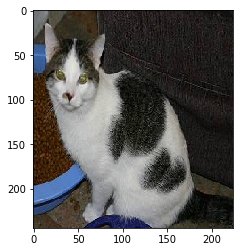

In [0]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
import numpy as np

#test_image 한개 접근
test_image = '/content/gdrive/My Drive/dataset/test/cat/cat.95.jpg'

img = image.load_img(test_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img)
print(img_tensor.shape)

In [0]:
from tensorflow.python.keras import models

layer_outputs = [layer.output for layer in new_model.layers[:8]]
activation_model = models.Model(inputs=new_model.input, outputs=layer_outputs)

(1, 244, 224, 64)


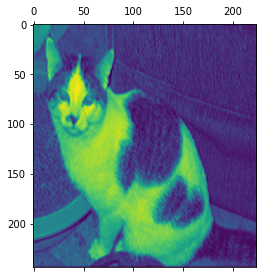

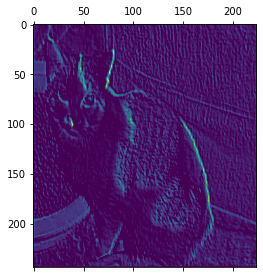

In [0]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[2]

print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 2], cmap = 'viridis')
plt.matshow(first_layer_activation[0, :, :, 40], cmap = 'viridis')
plt.show()

In [0]:
def Layer_predict(model, image):
  output_layers = [layer.output for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]
  output_names = [layer.name for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]

  show_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
  # 예측_A
  show_model_pred = show_model.predict(image)
  #print(model_A_pred[0])
  for pred_layer in show_model_pred:
    print(pred_layer.shape)
  return show_model_pred, output_names

layer_outputs, layer_names = Layer_predict(new_model, img_tensor)

(1, 244, 224, 64)
(1, 244, 224, 64)
(1, 122, 112, 64)
(1, 122, 112, 128)
(1, 122, 112, 128)
(1, 61, 56, 128)
(1, 61, 56, 256)
(1, 61, 56, 256)
(1, 61, 56, 256)
(1, 30, 28, 256)
(1, 30, 28, 512)
(1, 30, 28, 512)
(1, 30, 28, 512)
(1, 15, 14, 512)
(1, 15, 14, 512)
(1, 15, 14, 512)
(1, 15, 14, 512)
(1, 7, 7, 512)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


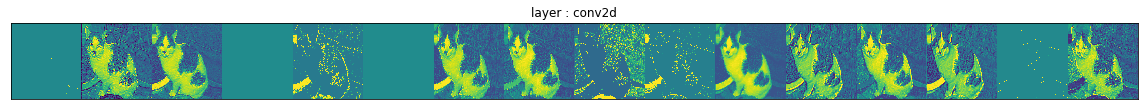

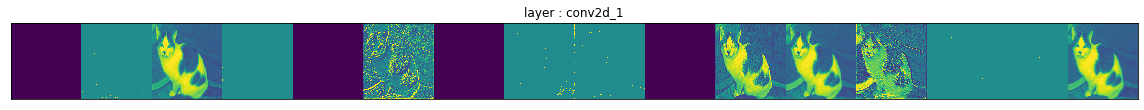

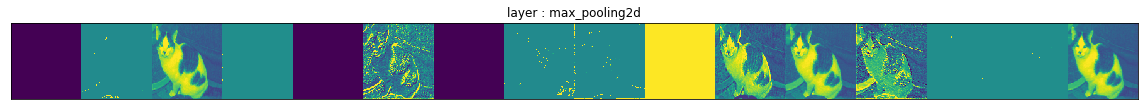

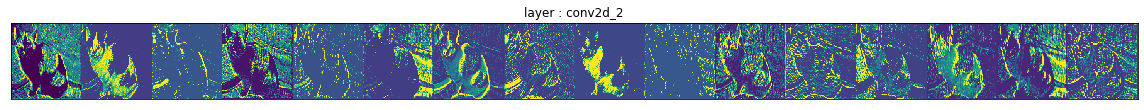

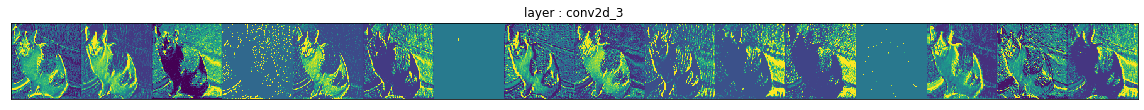

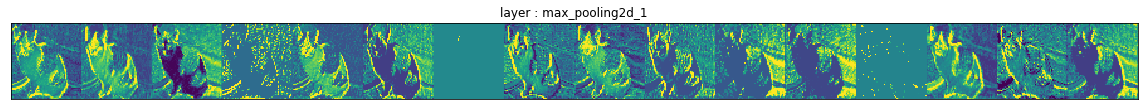

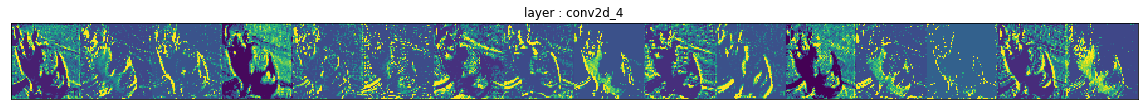

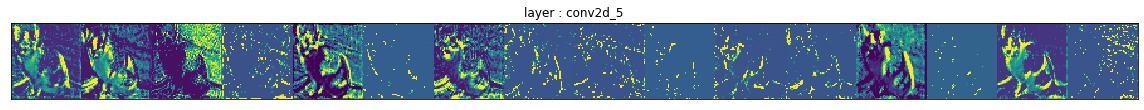

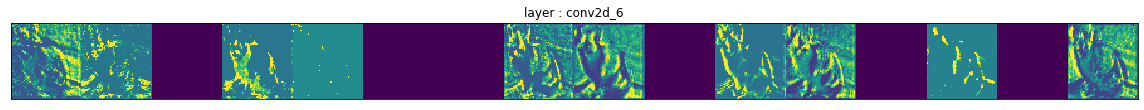

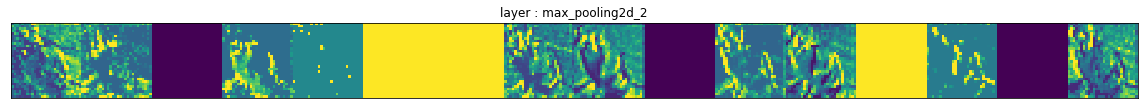

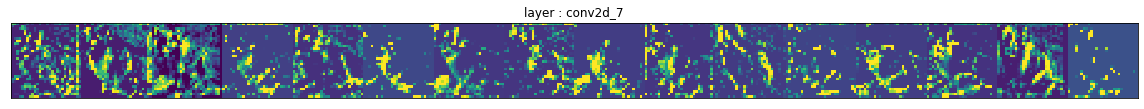

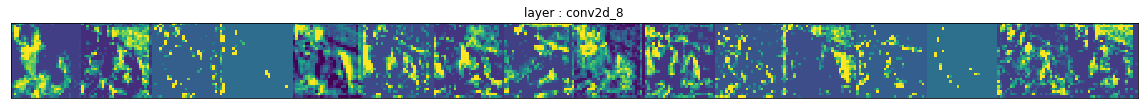

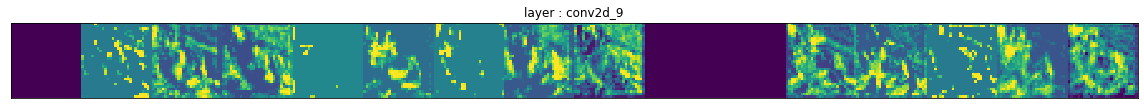

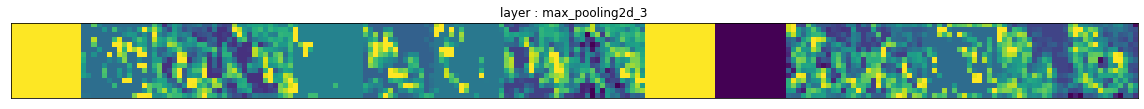

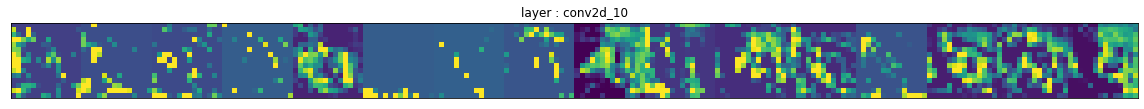

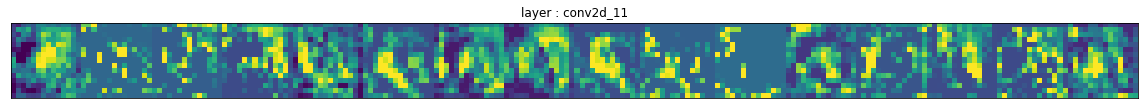

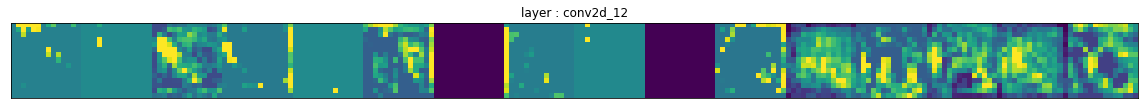

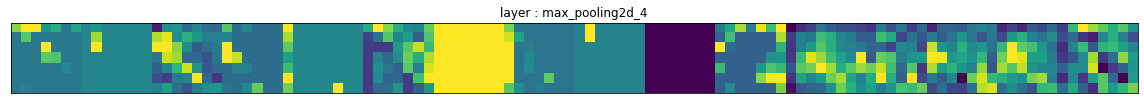

In [0]:
def show_predict_image(show_model_pred,output_names):
    n_col= 16
    _, size2, size, n_features = show_model_pred.shape
    n_row = n_features //n_col
    # feature_map_image = np.zeros(shape=(size2*n_row,size*n_col),dtype=('uint8'))
    feature_map_image = np.zeros(shape=(size2,size*n_col),dtype=('uint8'))
    
    for row in range(1):
        for col in range(n_col):   
            input_fmi = show_model_pred[0,:,:,row*n_col+col]

            input_fmi -= input_fmi.mean()
            input_fmi /= input_fmi.std()
            input_fmi *= 64
            input_fmi += 128
            input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

            feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

    plt.figure(figsize=(n_col, n_row))
    plt.xticks([])
    plt.yticks([])
    plt.title('layer : {}'.format(output_names))
    plt.tight_layout()
    plt.imshow(feature_map_image,cmap='viridis')

for layer, name in zip(layer_outputs, layer_names):
  show_predict_image(layer, name)
plt.tight_layout()
plt.show()

#heatmap

In [0]:
img = image.load_img(test_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
preds = new_model.predict(x)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("top index:", np.argmax(preds[0]))

ValueError: ignored